###### Mélissa EVEILLARD - M1 IMB

##  Analyse des transactions de paiement sur les horodateurs parisiens en 2014

Dans ce projet nous allons travailler avec le jeu de données *horodateurs*, disponible sur le site *opendata.paris*, qui recense l'ensemble des transactions effectuées sur les horodateurs de Paris en 2014.

On commence par importer les librairies que nous allons utiliser et le serveur `MongoDB` qui contient la base horodateurs.

In [80]:
import pymongo
import pandas
import pprint
import seaborn
import folium
import json
import matplotlib.pyplot as plt

geo = json.load(open("paris-arrondissements.geojson"))

def affiche(res):
    pprint.pprint(list(res))

centre = [48.86, 2.35]

#carte = folium.Map(location = centre, zoom_start = 12)
#carte.choropleth(geo_data = geo)
#carte
    
    
%matplotlib inline
con = pymongo.MongoClient("mongodb://193.51.82.104:2343/")

horo = con.horodateurs
horo.list_collection_names()

['transactions_small', 'myresults', 'transactions', 'mobiliers']

Nous avons à notre disposition 4 collections de données. Pour ce projet, nous travaillerons avec les collections **transactions_small** et **mobiliers** qui contiennent, respectivement, un nombre réduit de l'ensemble des paiements et la liste de tous les horodateurs présents à Paris.

Affichons tout d'abord le nombre de transactions qu'il y a eu en 2014.

In [3]:
# Nombre de transactions 
horo.transactions.estimated_document_count()

24448030

In [3]:
horo.transactions_small.estimated_document_count()

244480

En 2014, 24 448 030 paiements ont été faits sur les horodateurs de Paris. La base de données que nous utiliserons recense, quant à elle, 244 480 transactions. Regardons ce chiffre selon les arrondissements : 

In [44]:
nb_tran = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "nbtran"
    }},
    { "$unwind" : "$nbtran"},
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1 }}},
    { "$project": { "Arrondissement": "$_id", "NbTransactions": "$nb", "_id": 0 }},
    { "$sort" : {"Arrondissement": 1}}
])))

nb_tran

,Arrondissement,NbTransactions
0,1,2539
1,2,1787
2,3,4250
3,4,3884
4,5,9005
5,6,6784
6,7,12024
7,8,15113
8,9,8021
9,10,5487


Afin d'avoir une lecture plus visible de ces données on les représente avec un diagramme en barres.

Text(0.5, 1.0, 'Nombre de transactions selon les arrondissements')

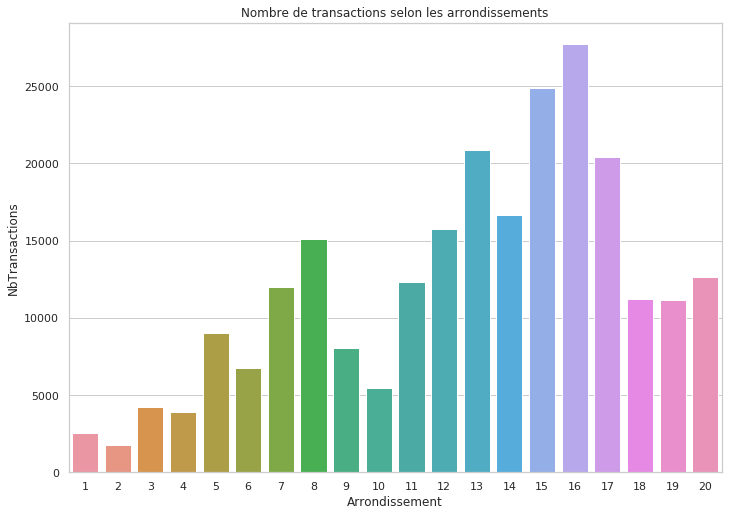

In [134]:
seaborn.barplot(y = "NbTransactions", x = "Arrondissement", data = nb_tran).set_title("Nombre de transactions selon les arrondissements")

Nous constatons que c'est dans le $16^e$ arrondissement qu'il y a eu le plus de transactions (27718). L'arrondissement où il y a eu le plus faible nombre de transactions est le $2^e$ arrondissement, avec 1787 transactions effectués en 2014.

Intéressons-nous, également, au montant que représente ces transactions effectuées.

In [97]:
res = pandas.DataFrame(list(horo.transactions_small.aggregate([ 
    { "$group": { "_id": None, "Total": { "$sum": "$montant carte" }}}
])))

res

,Total,_id
0,623191.79,None


En 2014, la somme total des transactions s'élevait à 623 191,79 €. Selon les arrondissements ce total diffère comme nous le montrons ci-dessous:

In [46]:
total_tran = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "total_tran"
    }},
    { "$unwind" : "$total_tran"},
    { "$group" : { "_id" : "$fields.arrondt", "Total" : { "$sum" : "$total_tran.montant carte" }}},
    { "$project": { "Arrondissement": "$_id", "Total": "$Total", "_id": 0 }},
    { "$sort": {"Arrondissement": 1}}
])))
total_tran

,Arrondissement,Total
0,1,10083.67
1,2,7466.09
2,3,16828.43
3,4,14237.47
4,5,32905.31
5,6,25233.70
6,7,45635.66
7,8,52881.66
8,9,24646.26
9,10,15431.90


C'est dans le $2^e$ arrondissement que le total des transactions est le plus faible puisqu'étant de 7 466,09 € pour l'année 2014 et c'est le $6^e$ arrondissement qui a la somme de transactions la plus élevée (64 843,64 €).

In [6]:
# Moyenne montant transaction 
affiche(horo.transactions_small.aggregate([
    { "$group": { "_id": None, "MontantTransactionMoyen": { "$avg": "$montant carte" }}}
]))


[{'MontantTransactionMoyen': 2.5490606146131163, '_id': None}]


En moyenne, en 2014, le montant payé par les usagers était de 2.55€. La moyenne des transactions par arrondissements est affichée ci-dessous :  

In [66]:
moy_arrdt = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "moy_arrdt"
    }},
    { "$unwind" : "$moy_arrdt"},
    { "$group" : { "_id" : "$fields.arrondt", "Total" : { "$avg" : "$moy_arrdt.montant carte" }}},
    { "$project": { "Arrondissement": "$_id", "MoyenneTransactions": "$Total", "_id": 0 }},
    { "$sort": {"Arrondissement": 1}}
])))

moy_arrdt


,Arrondissement,MoyenneTransactions
0,1,3.971512
1,2,4.178002
2,3,3.959631
3,4,3.665672
4,5,3.654115
5,6,3.719590
6,7,3.795381
7,8,3.499084
8,9,3.072717
9,10,2.812448


Ainsi, nous voyons que c'est le $19^e$ arrondissement qui a la plus faible moyennne des transactions avec 1.74€, contre 4.18€ pour le $2^e$ arrondissement qui arrive en tête du classement. On illustre ces données avec le graphique suivant: 

Text(0.5, 0.98, 'Moyenne des transactions par arrondissement')

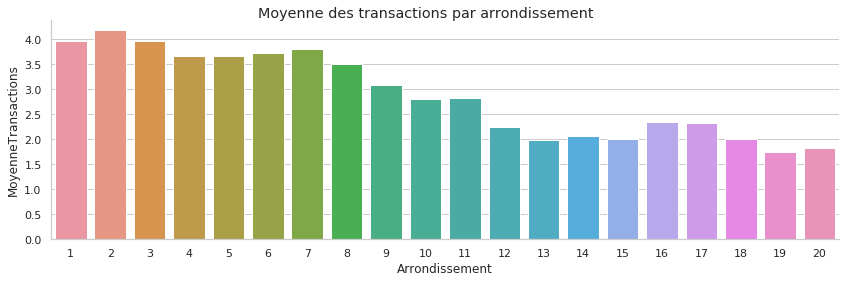

In [219]:
seaborn.set(style = "whitegrid")
seaborn.catplot(x = "Arrondissement", y = "MoyenneTransactions",
                data = moy_arrdt, kind = "bar", height = 4, aspect = 3).fig.suptitle("Moyenne des transactions par arrondissement")

---

Intéressons nous à présent aux mobiliers que l'on retrouve à Paris. 

In [116]:
# Nombre d'horodateurs
horo.mobiliers.estimated_document_count()

7810

En 2014, la ville de Paris comptait 7810 horodateurs. Selon les arrondissements la distribution était la suivante: 

In [9]:
nb_horo = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1}}},
    { "$sort" : { "_id": 1}},
    { "$project": { "Arrondissement": "$_id", "Quantité": "$nb", "_id": 0 }}, 
])))
nb_horo

,Arrondissement,Quantité
0,1,87
1,2,67
2,3,133
3,4,135
4,5,267
5,6,174
6,7,361
7,8,376
8,9,227
9,10,197


On représente ces informations à l'aide d'une carte.

In [40]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = nb_horo, columns = ["Arrondissement", "Quantité"],
                 fill_color= "YlGn",
                 legend_name = "Nombre horodateurs par arrondissement").add_to(carte)
carte

C'est dans le $16^e$ arrondissement qu'on retrouve le plus grand nombre d'horodateurs; il y en a 959. L'arrondissement qui compte le plus faible nombre d'horodateurs est le $2^e$ où l'en on trouve 67. 

Grâce à la carte, nous pouvons nous aperçevoir que le centre paris comporte peu d'horodateurs; les 10 premiers arrondissement ont tous moins de 300 horodateurs. Les arrondissment avec le plus de mobiliers sont ceux plus éloignés du centre. 

Les mobiliers sont alimentés de 2 façons différentes; par pile ou énergie solaire. 

In [94]:
horo.mobiliers.distinct("fields.alim")

['SOLAIRE', 'PILE']

La réparition des mobiliers selon leur mode d'alimentation est la suivante : 

In [100]:
alim_mobilier = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.alim", "Total" : { "$sum" : 1 }}},
    { "$project": { "TypeAlimentation": "$_id", "Quantité": "$Total", "_id": 0 }}
])))
alim_mobilier

,Quantité,TypeAlimentation
0,8,None
1,2994,PILE
2,4808,SOLAIRE


Text(0.5, 1.0, "Répartition des horodateurs en fonction du type d'alimentation")

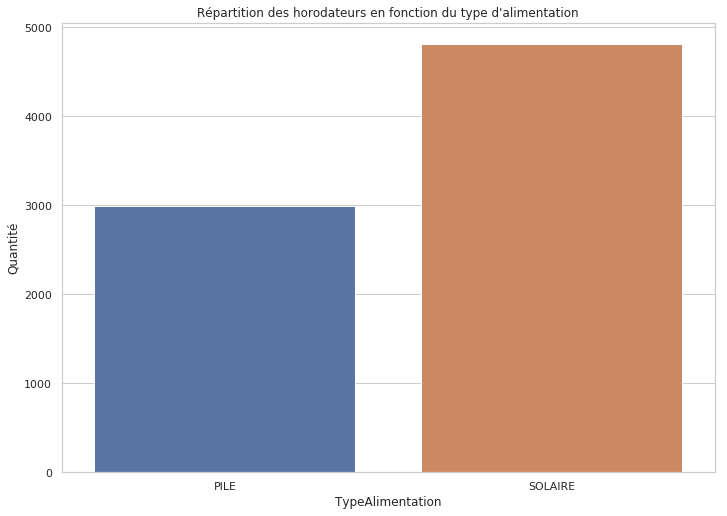

In [113]:
seaborn.set(style = "whitegrid")
seaborn.barplot(x = "TypeAlimentation", y = "Quantité", data = alim_mobilier).set_title("Répartition des horodateurs en fonction du type d'alimentation")

La majorité des horodateurs disponibles à Paris fonctionne par énergie solaire; on en comptre 4808 dans toute la ville (soit 62% de l'ensemble des mobiliers). 

Il serait intéressant de voir cette répartition selon les arrondissements. Ci-dessous, le tableau répertoriant le nombre d'horodateurs par arrondissement selon leur type d'alimentation

In [24]:
type_alim = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : {"Arrondissement": "$fields.arrondt", "Alimentation": "$fields.alim"}, "nb" : { "$sum" : 1 }}},
    { "$project": { "Arrondissement": "$_id.Arrondissement", "Alimentation": "$_id.Alimentation", "Quantité": "$nb", "_id": 0 }},
    { "$sort" : {"Arrondissement": 1}}
])))
type_alim

,Alimentation,Arrondissement,Quantité
0,SOLAIRE,1,85
1,NaN,1,2
2,SOLAIRE,2,67
3,SOLAIRE,3,133
4,SOLAIRE,4,135
5,SOLAIRE,5,34
6,PILE,5,233
7,PILE,6,57
8,SOLAIRE,6,117
9,SOLAIRE,7,45


Afin de rendre cette information plus compréhensible , nous la représentons à l'aide d'une carte. On crée 2 dataframes comptabilisant pour chaque quartier le nombre de mobiliers selon le type d'alimentation. 

In [28]:
# Dataframe regroupant le nb d'horodateurs solaires par arrondissement 
solaire = type_alim["Quantité"][type_alim["Alimentation"]== "SOLAIRE"]
arrdt_solaire = type_alim["Arrondissement"][type_alim["Alimentation"]== "SOLAIRE"]
solaire = pandas.DataFrame({"NbHoroSolaire" : solaire, "Arrondissement": arrdt_solaire})
solaire.head()

,NbHoroSolaire,Arrondissement
0,85,1
2,67,2
3,133,3
4,135,4
5,34,5


In [31]:
# Dataframe regroupant le nb d'horodateurs avec pile par arrondissement 
pile = type_alim["Quantité"][type_alim["Alimentation"]== "PILE"]
arrdt_pile = type_alim["Arrondissement"][type_alim["Alimentation"]== "PILE"]
pile = pandas.DataFrame({"NbHoroPile" : pile, "Arrondissement": arrdt_pile})
pile.head()


,NbHoroPile,Arrondissement
6,233,5
7,57,6
10,316,7
13,1,9
15,189,10


Nous pouvons maintenant regrouper ces informations sur une carte interactive.

In [48]:
carte = folium.Map(location = centre, zoom_start = 12)

## Info horodateurs solaire
choropleth = folium.Choropleth(
    geo_data=geo,
    data=solaire,
    columns=['Arrondissement', 'NbHoroSolaire'],
    key_on='feature.properties.c_ar',
    fill_color='YlOrBr',
    name='Solaire',
    show=True,
    nan_fill_color = 'purple',
    legend_name = "Nombre horodateurs solaire par arrondissement"
).add_to(carte)



## Info horodateurs pile
choropleth2 = folium.Choropleth(
    geo_data=geo,
    data=pile,
    columns=['Arrondissement', 'NbHoroPile'],
    key_on='feature.properties.c_ar',
    fill_color='YlGnBu',
    name='Pile',
    show=False,
    nan_fill_color = 'black',
    legend_name = "Nombre horodateurs avec pile par arrondissement"
).add_to(carte)


### 

print(type(choropleth.geojson))
print(type(choropleth.color_scale))


print(type(choropleth2.geojson))
print(type(choropleth2.color_scale))


folium.LayerControl(collapsed=False).add_to(carte)
carte

<class 'folium.features.GeoJson'>
<class 'branca.colormap.StepColormap'>
<class 'folium.features.GeoJson'>
<class 'branca.colormap.StepColormap'>


----

Pour finir, intéressons nous aux usagers. En moyenne, la durée de stationnenement était d'environ 8h.

In [47]:
affiche(horo.transactions_small.aggregate([
    { "$group": { "_id": None, "MoyenneDuréeStationnement": { "$avg": "$durée payée (h)" }}}
]))


[{'MoyenneDuréeStationnement': 8.258041434882198, '_id': None}]


In [51]:
duree_arrdt = pandas.DataFrame(list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "moy_duree"
    }},
    { "$unwind" : "$moy_duree"},
    { "$group" : { "_id" : "$fields.arrondt", "Total" : { "$avg" : "$moy_duree.durée payée (h)" }}},
    { "$project": { "Arrondissement": "$_id", "MoyenneDureePayees": "$Total", "_id": 0 }},
    { "$sort": {"Arrondissement": 1}}
])))

duree_arrdt

,Arrondissement,MoyenneDureePayees
0,1,5.355431
1,2,5.149245
2,3,6.019835
3,4,7.788177
4,5,8.019469
5,6,7.416420
6,7,9.851005
7,8,6.193805
8,9,7.147338
9,10,7.887704


Text(0.5, 0.98, 'Durée moyenne de stationnement par arrondissement')

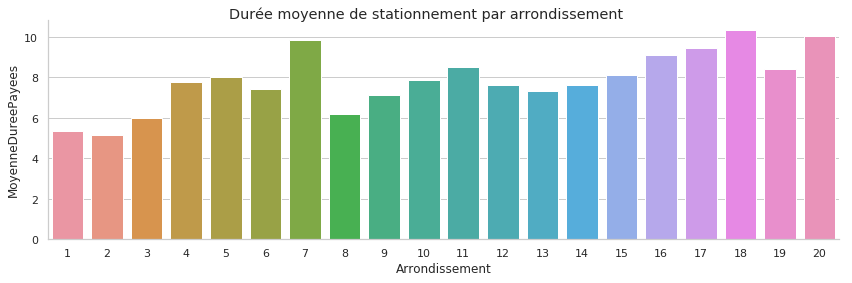

In [59]:
seaborn.set(style = "whitegrid")
seaborn.catplot(x = "Arrondissement", y = "MoyenneDureePayees",
                data = duree_arrdt, kind = "bar", height = 4, aspect = 3).fig.suptitle("Durée moyenne de stationnement par arrondissement")

C'est dans le 18e arrondissement que les automobilistes ont stationné le plus de temps; avec une moyenne de 10h de stationnement. L'arrondissement où les automobliste stationnent le moins est le 2e avec 5h de stationnnement en moyenne.

Les usagers payent leur stationnement sur les horodateurs en utilisant différents moyens de paiement.

In [60]:
type_paiement = pandas.DataFrame(list(horo.transactions_small.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "Total" : { "$sum" : 1 }}},
    { "$project": { "MoyenPaiement": "$_id", "Nombre": "$Total", "_id": 0 }}
])))
type_paiement

,MoyenPaiement,Nombre
0,CB,112027
1,Paris Carte,132453


Text(0.5, 1.0, 'Mode de paiment des usagers')

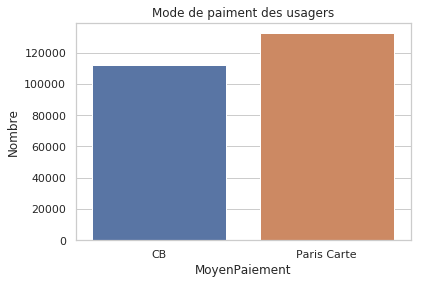

In [61]:
seaborn.set(style = "whitegrid")
seaborn.barplot(x = "MoyenPaiement", y = "Nombre", data = type_paiement).set_title("Mode de paiment des usagers")

Les personnes qui ont stationné dans Paris ont légèrement plus utilisé la carte "Paris Carte" pour payer leur stationnement plutôt que leur carte bancaire (132 453 paiements contre 112 027).